## Lab 8: Feature Selction & Model Comparison

In this lab, we will compare different types of linear (and nonlinear) models as well as how we pick the data to train them on.

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
%matplotlib inline

### Importing and Cleaning Data

In [4]:
df2=pd.read_excel("/Users/andre/Merced_Research/Chem290ds/data/AirQualityUCI.xlsx")
df2.describe()

,Date,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,2004-09-21 04:30:05.193972480,-34.207524,1048.869652,-159.090093,1.865576,894.475963,168.604200,794.872333,58.135898,1391.363266,974.951534,9.776600,39.483611,-6.837604
min,2004-03-10 00:00:00,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,2004-06-16 00:00:00,0.600000,921.000000,-200.000000,4.004958,711.000000,50.000000,637.000000,53.000000,1184.750000,699.750000,10.950000,34.050000,0.692275
50%,2004-09-21 00:00:00,1.500000,1052.500000,-200.000000,7.886653,894.500000,141.000000,794.250000,96.000000,1445.500000,942.000000,17.200000,48.550000,0.976823
75%,2004-12-28 00:00:00,2.600000,1221.250000,-200.000000,13.636091,1104.750000,284.200000,960.250000,133.000000,1662.000000,1255.250000,24.075000,61.875000,1.296223
max,2005-04-04 00:00:00,11.900000,2039.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,88.725000,2.231036
std,NaN,77.657170,329.817015,139.789093,41.380154,342.315902,257.424561,321.977031,126.931428,467.192382,456.922728,43.203438,51.215645,38.976670


In [16]:
nose_cols=['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)']
GT_cols=['CO(GT)','NMHC(GT)','C6H6(GT)','NOx(GT)','NO2(GT)']
env_cols=['T','RH','AH']


df2=df2.replace(-200,np.nan)
input_filter=np.ones(len(df2)).astype(bool)
for col in nose_cols+env_cols:
    input_filter=input_filter & df2[col].notnull()

nose_data=df2[input_filter][nose_cols+env_cols]
nose_data_avg=np.average(nose_data,axis=0)
nose_data_std=np.std(nose_data,axis=0)

nose_data_normalized=(nose_data-nose_data_avg)/nose_data_std


GT_record=dict()
for col in GT_cols:
    filter=df2[col].notnull()

    GT_data=df2[filter][col]
    GT_data_avg=np.average(GT_data)
    GT_data_std=np.std(GT_data)

    GT_data_normalized=(GT_data-GT_data_avg)/GT_data_std
    GT_record[col]={"data":GT_data_normalized,"filter":filter,"avg":GT_data_avg,"std":GT_data_std}
    
    
data_filter=input_filter & GT_record["CO(GT)"]["filter"] & GT_record["NOx(GT)"]["filter"]
mlinputs=nose_data_normalized[data_filter].values
mloutputs=(GT_record["C6H6(GT)"]["data"][data_filter].values.reshape((-1,1)))

nose_data_normalized['C6H6(GT)'] = df2["C6H6(GT)"]
final = nose_data_normalized[data_filter]
final.head()

C:\Users\andre\AppData\Local\Temp\ipykernel_22596\333477304.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mlinputs=nose_data_normalized[data_filter].values
C:\Users\andre\AppData\Local\Temp\ipykernel_22596\333477304.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final = nose_data_normalized[data_filter]


,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,C6H6(GT)
0,1.199102,0.399045,0.860118,0.681301,0.614165,-0.533950,-0.020638,-0.663157,11.881723
1,0.886995,0.058920,1.317671,0.296392,-0.126815,-0.567915,-0.088497,-0.743065,9.397165
2,1.392586,0.000828,1.186246,0.284115,0.128543,-0.726423,0.273897,-0.681767,8.997817
3,1.270507,0.034559,0.999331,0.368608,0.452918,-0.828320,0.621852,-0.591440,9.228796
4,0.794860,-0.388020,1.439361,0.097799,0.218892,-0.811337,0.597308,-0.586284,6.518224


## Linear Regression

In Lab 6 we saw how we can use the `LinearRegression` model available in sklearn to perform an OLS fit using multivariate data.

In [17]:
model = LinearRegression(fit_intercept=True)
model.fit(X = final[['PT08.S3(NOx)','T']], y = final['C6H6(GT)'])
predicted_vals = model.predict(X = final[['PT08.S3(NOx)','T']])

# Do not modify below this line.
r2_hp_sqrt = np.var(predicted_vals) / np.var(final['C6H6(GT)'])
print('Multiple R^2: ', r2_hp_sqrt)

Multiple R^2:  0.5403908401635985


In the example above we chose two arbitrary features to use as our model inputs. We could obviously feed in all available features as inputs, but for the moment let's take a step back and think about how we would go about choosing the best features to train our linear model with.

For linear models, we are most interested in features that share high correlation with our target output feature. An easy way to get examine that correlation accross our entire dataset is to use the `sns.heatmap` function provided in the seaborn library.

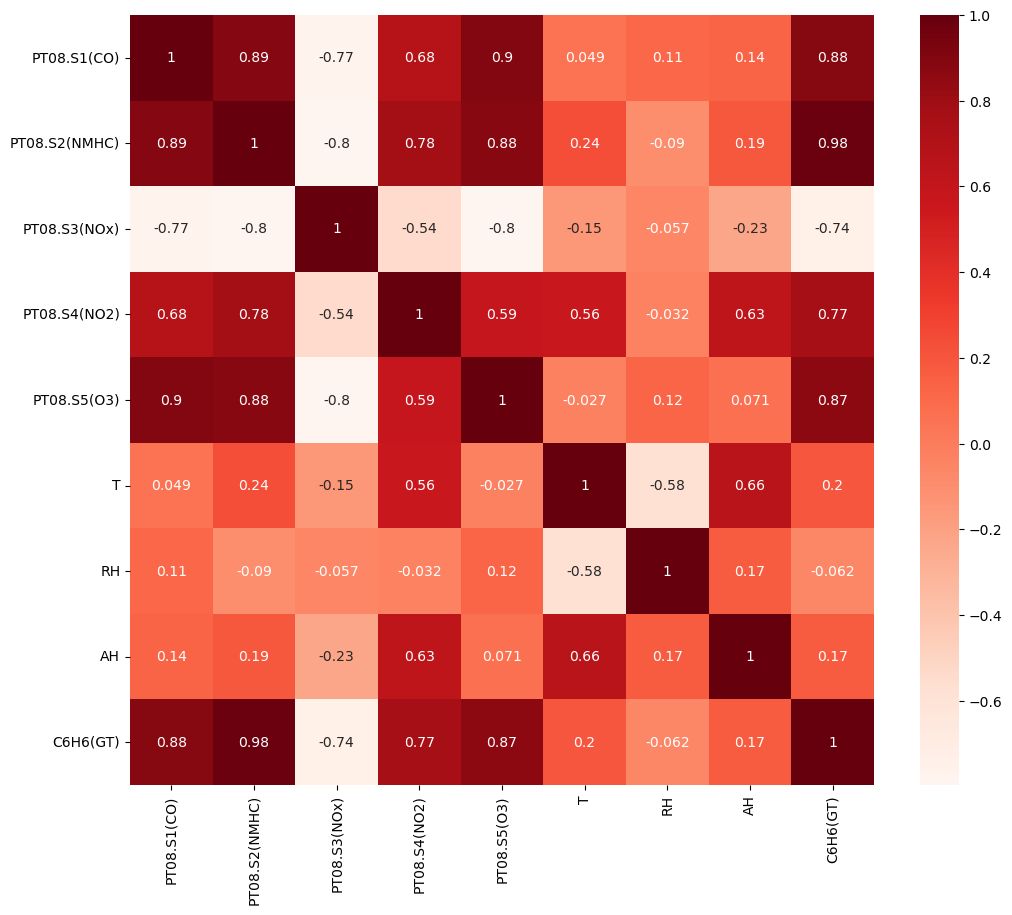

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,10))
cor = nose_data_normalized.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Question 1:
Construct and compare two models, one using the 'best' two features, and one using the 'worst' two features as inputs. How big a role does feature selection play in model performance?

## LASSO Regression

LASSO models can be constructed in much the same way as our previous linear models.

In [19]:
modelLA = Lasso(alpha=1.0)

modelLA.fit(X = final[['PT08.S3(NOx)','T']], y = final['C6H6(GT)'])

predicted_vals = modelLA.predict(X = final[['PT08.S3(NOx)','T']])

# Do not modify below this line.
r2_hp_sqrt = np.var(predicted_vals) / np.var(final['C6H6(GT)'])
print('Multiple R^2: ', r2_hp_sqrt)

Multiple R^2:  0.34698738053184086


### Question 2:
The key hyperparamater in LASSO models is the value of alpha (or $\lambda$ in some notations). Write a function that searches through the given range of alpha values and report which gives a model with the highest R2 result.

In [22]:
alphas = np.arange(0, 1, 0.01)
...

## Neural Networks

In cases where linear models may not be capable of capturing the nuanced relationships between our dataset features, neural networks provide a promising alternative. Below is a basic example written using PyTorch, a popular Python ML framework.

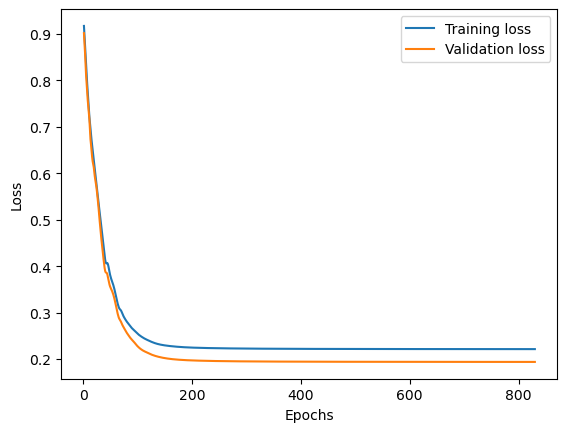

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

class PyTorchNetwork(nn.Module):
    def __init__(self, architecture, activation='tanh', default_weights=False):
        super(PyTorchNetwork, self).__init__()

        layers = []
        if default_weights:
            init = nn.init.uniform_
        else:
            init = nn.init.uniform_

        for i in range(len(architecture) - 1):
            layers.append(nn.Linear(architecture[i], architecture[i + 1]))
            layers.append(self.get_activation(activation))
            init(layers[-2].weight)
            init(layers[-2].bias)

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def get_activation(self, activation):
        if activation == 'tanh':
            return nn.Tanh()
        elif activation == 'relu':
            return nn.ReLU()
        elif activation == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Activation function {activation} not supported")

def calc_mse(predictions, targets):
    return np.mean((predictions - targets) ** 2)

def train_and_evaluate(model, X_train, y_train, X_test, y_test, total_epochs=500, draw_curve=True):
    train_array = []
    val_array = []

    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(total_epochs):
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate on validation set
        val_loss = criterion(model(X_test_tensor), y_test_tensor)

        train_array.append(loss.item())
        val_array.append(val_loss.item())

        if len(val_array) > 3 and val_array[-1] > val_array[-2] and val_array[-2] > val_array[-3]:
            # Early stopping condition (3 consecutive increases in validation loss)
            break

    if draw_curve:
        plt.plot(np.arange(len(train_array)) + 1, train_array, label='Training loss')
        plt.plot(np.arange(len(val_array)) + 1, val_array, label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    return model

# Example usage:
# Define your data (Xs, ys)
# Set the architecture of the neural network
architecture = [8, 16, 8, 1]

# Instantiate the PyTorch model
pytorch_model = PyTorchNetwork(architecture, activation='tanh', default_weights=False)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mlinputs, mloutputs, test_size=0.2, random_state=42)

# Train and evaluate the PyTorch model
trained_model = train_and_evaluate(pytorch_model, X_train, y_train, X_test, y_test,5000)

In [35]:
preds = trained_model.forward(torch.FloatTensor(inputs)).detach().numpy()
r2_ml = r2_score(mloutputs,preds)
print('Multiple R^2: ', r2_ml)

Multiple R^2:  0.7850478362833117


### Question 3:
The NN above used an architechture with 2 hidden layers, the first with 16 nodes, the 2nd with 8. Compare the results to models trained with the other two architectures given below.

In [37]:
architecture2 = [8, 16, 1]
architecture3 = [8, 1]